# King’s Super Math Saga experiment

### Data Description

The assignment table contains players assigned to the A/B test and attributes related to each player.
1. playerid: Unique numeric identifier for each player
2. abtest_group: The group the player was assigned to (A or B)
3. assignment_date: The date when the player was assigned to the test
4. install_date: The date when the player installed the game
5. conversion_date: The date when the player made their first purchase

The activity table contains player activity for each day a player was active.
1. playerid: Unique numeric identifier for each player
2. activity_date: The date of activity
3. purchases: Number of purchases made this day
4. gameends: Number of gamerounds played this day

### Hypothesis Test

Assumptions:

    - Check for normality
    - If normal distribution, check for homogeneity

Steps:

    - Apply Shapiro Test for normality
    - If parametric, apply Levene Test for homogeneity of variances
    - If parametric + homogeneity of variances apply T-Test
    - If parametric - homogeneity of variances apply Welch Test
    - If non-parametric apply Mann Whitney U Test

In [212]:
# define function that checks assumptions and applies appropriate hypothesis test
def hypothesis_test(test, control, alternative="two-sided"):

    # import packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # check for normality:
    ntA = shapiro(test)[1] < 0.05
    ntB = shapiro(control)[1] < 0.05

    if (ntA == False) & (ntB == False): 
        # parametric test
        # check for homogeneity
        leveneTest = stats.levene(test, control)[1] < 0.05

        if leveneTest == False: # homogeneus
            ttest = stats.ttest_ind(test, control, equal_var=True, alternative=alternative)
        else: # heterogeneous
            ttest = stats.ttest_ind(test, control, equal_var=False, alternative=alternative)
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(test, control, alternative=alternative)

    return ttest

### Packages

In [187]:
# import packages

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GCP
import pandas_gbq
import db_dtypes

# Hypothesis Testing
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Extraction & Prep

In [53]:
# define function to query data from gcp and transform it into df
def gcp2df(query):
    project_id = 'king-ds-recruit-candidate-635'
    return pd.read_gbq(query, project_id=project_id, dialect='standard')

In [300]:
query = ('''
    WITH

    activity AS (
    SELECT playerid, SUM(purchases) AS total_purchases, SUM(gameends) as total_gameends
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
        GROUP BY playerid
    ),

    joinTables AS (
    SELECT ass.*, ac.total_gameends, ac.total_purchases
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    )

    SELECT *
    FROM joinTables
    ''')

df = gcp2df(query)

In [301]:
 # format date variables into datetime
df[["assignment_date", "install_date", "conversion_date"]] = df[["assignment_date", "install_date", 
                                                                "conversion_date"]].apply(pd.to_datetime)

In [302]:
# create more meaningful and actionable variables form datetime variables
df["days_since_installed"] = (df.assignment_date.max() - df.install_date).dt.days # time since a player installed the game in days
df["days_to_convert"] = (df.conversion_date - df.install_date).dt.days # time it takes players to convert after installing the game in days

In [303]:
# create a player_type variable that segments players by days_since_installed
# The split is determined by business sense
conditions = [
    (df.days_since_installed <= 19), # new players that haven't seen the control version
    (df.days_since_installed > 19) & (df.days_since_installed <= 90),
    (df.days_since_installed > 90)]
values = ["newbie", "experienced", "OG"]
df["player_type"] = np.select(conditions, values)

In [304]:
# split control and test results
control_results = df[df["abtest_group"]=="A"]
test_results = df[df["abtest_group"]=="B"]

In [305]:
query1 = ('''
    WITH

    activity AS (
    SELECT *
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
    ),

    joinTables AS (
    SELECT ass.playerid, ass.abtest_group, ac.activity_date, ac.gameends, ac.purchases, 
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    ),

    avg_by_date AS (
    SELECT abtest_group, activity_date, AVG(gameends) AS avg_gameends, STDDEV(gameends) AS std_gameends, 
        SUM(gameends) AS n_gameends, AVG(purchases) AS avg_purchases, STDDEV(purchases) AS std_purchases, 
        SUM(purchases) AS n_purchases
    FROM joinTables
    GROUP BY 1, 2
    ORDER BY activity_date, abtest_group
    )

    SELECT *
    FROM avg_by_date
    ''')

df1 = gcp2df(query1)

## 2. Metric Analysis

In [306]:
df.head() # contains aggregated gameround and purchase data for the whole experiment

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gameends,total_purchases,days_since_installed,days_to_convert,player_type
0,49709407,A,2017-05-08,2017-05-08,NaT,71,0,14,NaN,newbie
1,49757983,A,2017-05-08,2017-05-08,2017-05-08,68,1,14,0.0,newbie
2,49689756,A,2017-05-08,2017-05-08,NaT,5,0,14,NaN,newbie
3,49735663,A,2017-05-08,2017-05-08,NaT,173,0,14,NaN,newbie
4,49723509,A,2017-05-08,2017-05-08,NaT,5,0,14,NaN,newbie


### Invariant metrics: *

    - playerid
    - days_since_installed

*Invariant metrics are those which should not change across control and experiment groups. If players were randomly assigned, we would expect the distributions of these metrics to stay consistent between the test and control sets, or else there is something fundamentally wrong with the experiment setup.

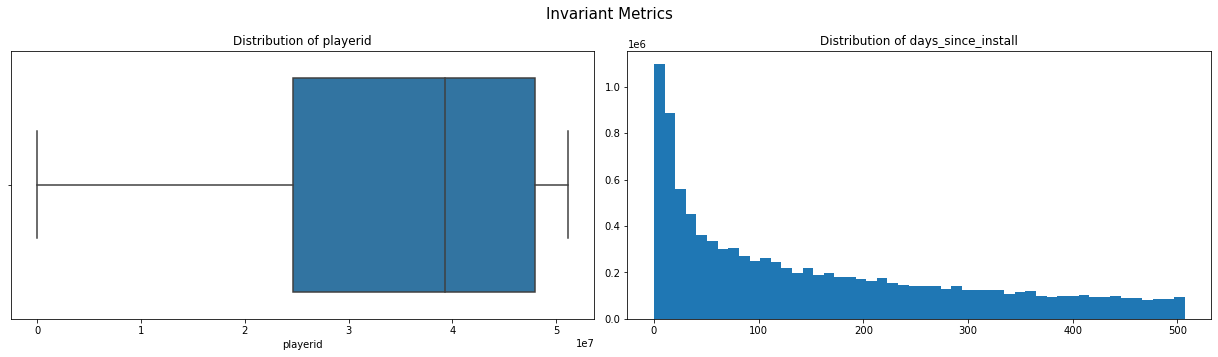

In [307]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.boxplot(df.playerid, ax=ax[0])
ax[1].hist(df.days_since_installed, bins=50)

fig.suptitle("Invariant Metrics", fontsize=15)
ax[0].set_title("Distribution of playerid", fontsize = 12)
ax[1].set_title("Distribution of days_since_install", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

#### Observations:

Most active players installed the game during the last few months.

### Evaluation metrics:

    - total_gameends (engagement)
    - total_purchases (monetization)
    - days_to_convert (monetization)

In [308]:
df[["days_to_convert", "total_gameends", "total_purchases"]].describe()

,days_to_convert,total_gameends,total_purchases
count,285923.000000,1.033106e+07,1.033106e+07
mean,2.720886,1.579491e+02,3.714809e-01
std,4.501814,1.391929e+02,9.515109e+00
min,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,9.500000e+01,0.000000e+00
50%,1.000000,1.290000e+02,0.000000e+00
75%,4.000000,1.820000e+02,0.000000e+00
max,84.000000,1.932000e+03,5.690000e+03


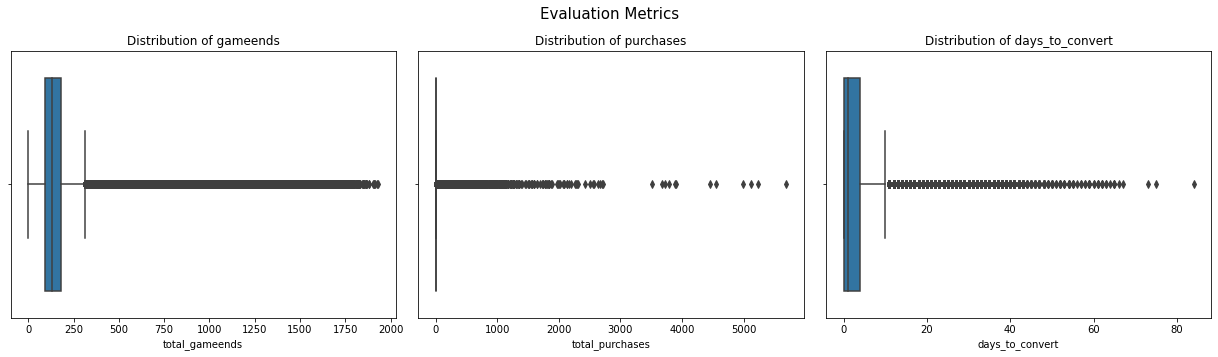

In [309]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
sns.boxplot(df.total_gameends, ax=ax[0])
sns.boxplot(df.total_purchases, ax=ax[1])
sns.boxplot(df.days_to_convert, ax=ax[2])

fig.suptitle("Evaluation Metrics", fontsize=15)
ax[0].set_title("Distribution of gameends", fontsize = 12)
ax[1].set_title("Distribution of purchases", fontsize = 12)
ax[2].set_title("Distribution of days_to_convert", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

In [310]:
# share of paying users
df.conversion_date.notnull().value_counts(normalize=True)

False    0.972324
True     0.027676
Name: conversion_date, dtype: float64

#### Observations:

Most players are Free-to-play. The share of paying users is around 2.8%.

Most paying users convert during the first few days of playing the game. If a player doesn't pay early on, is highly unlikely that they will end up paying. 

There is a high variance between the gamerounds and purchases made by different players. All paying users are considered outliers.

Some players have made more purchases than rounds played. This suggests that there are multiple hints in a level.

## 3. Sanity Checks

#### What checks can we do to be confident in the validity of the test?

In [311]:
# Are there duplicated playerids?
df.playerid.duplicated().any()

False

In [312]:
# Do the control and test groups contain 80 and 20 percent of the players respectively?
df.abtest_group.value_counts(normalize=True)

A    0.800074
B    0.199926
Name: abtest_group, dtype: float64

#### Checking invariants: are the distributions of invariant metrics for control and test groups the same?

In [313]:
# playerid
print(df.groupby("abtest_group").playerid.mean())
print(hypothesis_test(control_results.playerid, test_results.playerid))

abtest_group
A    34979639.729978
B    34983333.536522
Name: playerid, dtype: Float64


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# days_since_installed
print(df.groupby("abtest_group").days_since_installed.mean())
print(hypothesis_test(control_results.days_since_installed, test_results.days_since_installed))

abtest_group
A    159.306688
B    159.269564
Name: days_since_installed, dtype: float64
MannwhitneyuResult(statistic=8538072968530.0, pvalue=0.6041776844973805)


All the invariant metrics pass the test. The means of the distributions are very similar and we cannot reject that the underlying distribution is the same for the control and test groups. 

Since everything looks alright, we will go on and analyze the results of our evaluation metrics.

## 4. Results Analysis

### Aggregated Data

To consider the results as positive, we would like to see that the change made to the game, aka treatment, will result in a greater engagement and/or number of purchases. 

Thus, our null hypothesis (H0) and alternative hypothesis (Ha) are as follows:  

    - H0: There is no difference in the average number of gamerounds and/or purchases in the test and control groups.
    - Ha: The average number of gamerounds and/or purchases of the test group is greater than the control group.

Since the alternative hypothesis states that the true value of the parameter specified in the null hypothesis is greater than the null hypothesis claims, we will use a right-tailed test.

We choose our significance level to be 0.05. Thus, if p<=0.05, we reject the H0.

Let's first look into the gameround and purchases summary statistics for the different abtest_groups. 

In [ ]:
df[["abtest_group", "total_gameends", "total_purchases"]].groupby(by="abtest_group").agg(["count", 
                                                                "median", "mean", "std", "max"]).style.format('{:.3f}')

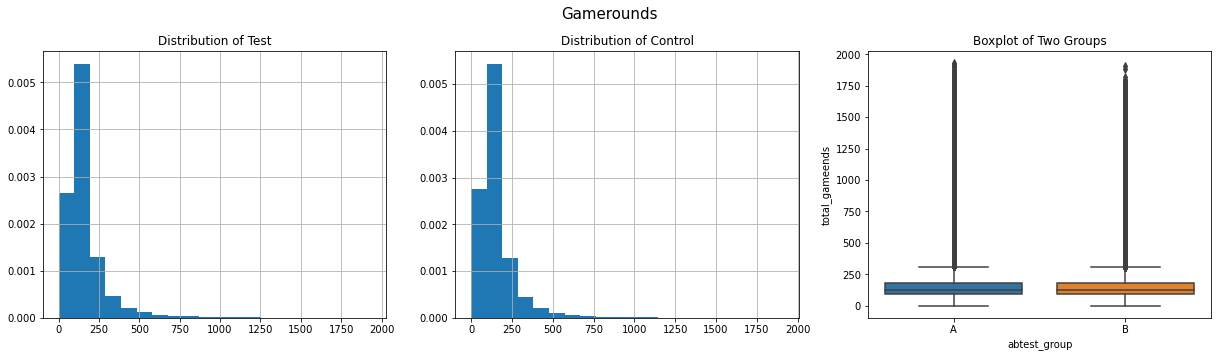

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_gameends", density=True, bins= 20, ax=ax[0])
test_results.hist("total_gameends", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_gameends", data=df, ax=ax[2])

fig.suptitle("Gamerounds", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

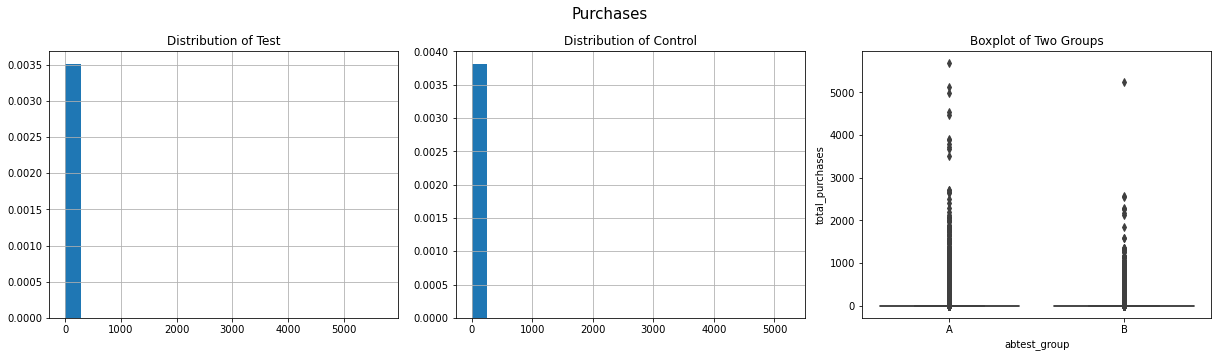

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_purchases", density=True, bins=20, ax=ax[0])
test_results.hist("total_purchases", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_purchases", data=df, ax=ax[2])

fig.suptitle("Purchases", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

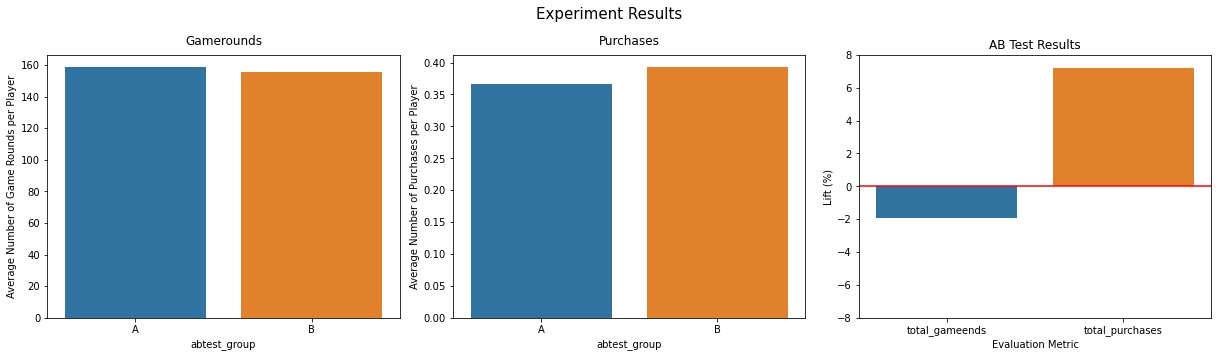

In [ ]:
grouped_df = df[["abtest_group", "total_gameends", "total_purchases"]].groupby(df["abtest_group"]).mean()
grouped_df_lift = (grouped_df.loc["B"] - grouped_df.loc["A"]) / grouped_df.loc["A"]

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(x=grouped_df.total_gameends.index, y=grouped_df.total_gameends, ax=ax[0])
sns.barplot(x=grouped_df.total_purchases.index, y=grouped_df.total_purchases, ax=ax[1])
sns.barplot(x=grouped_df_lift.index, y=grouped_df_lift*100, ax=ax[2])

fig.suptitle("Experiment Results", fontsize=15)
ax[0].set_title("Gamerounds", pad=10)
ax[0].set_ylabel("Average Number of Game Rounds per Player")
ax[1].set_title("Purchases", pad=10)
ax[1].set_ylabel("Average Number of Purchases per Player")
ax[2].set_ylim(-8, 8)
ax[2].set_title("AB Test Results")
ax[2].set_xlabel("Evaluation Metric")
ax[2].set_ylabel("Lift (%)")
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout(pad = 1)
plt.show()

It would seem that our treatment has resulted in a decrease in the average number of gamerounds per player of around 2% (bummer!), but a substantial increase of around 7% in the average number of purchases made. 

To confirm these results, we will perform hypothesis tests.

In [ ]:
hypothesis_test(test_results["total_gameends"], control_results["total_gameends"], alternative="less")

MannwhitneyuResult(statistic=8373836786400.0, pvalue=0.0)

In [ ]:
hypothesis_test(test_results["total_purchases"], control_results["total_purchases"], alternative="greater")

MannwhitneyuResult(statistic=8536180046875.0, pvalue=0.4901617437975493)

This shows that we can be confident that there is a difference between the average number of gamerounds between the two groups, but we do not have sufficient evidence to say that the true average number of purchases is different between the two groups.

### Daily Data

We also want to look at the daily average number of gamerounds and purchases evolve throughout the experiment. After launching a new game feature, there may be early transitional effects of the changes introduced in the variants. Looking at the daily averages, rather than the total averages, may yield some interesting information. Let's look at daily average data. 

In [ ]:
df1.head()  # contains the average number of gamerounds and purchases made each day of the experiment

,abtest_group,activity_date,avg_gameends,std_gameends,n_gameends,avg_purchases,std_purchases,n_purchases
0,A,2017-05-04,13.179551,10.238376,68597770,0.030555,0.757338,159035
1,B,2017-05-04,13.119000,10.180584,17040715,0.031852,0.775842,41374
2,A,2017-05-05,13.186148,10.250823,68498045,0.030470,0.768134,158282
3,B,2017-05-05,13.003362,10.096645,16868794,0.033394,0.772663,43321
4,A,2017-05-06,13.182186,10.235810,68755819,0.030389,0.771736,158504


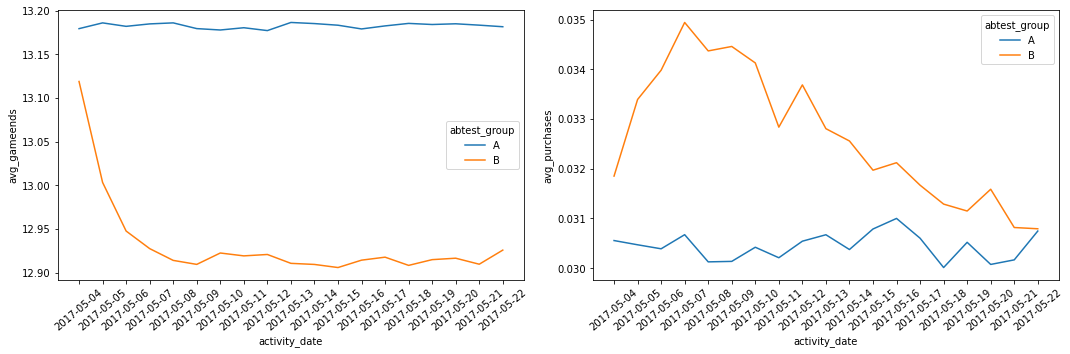

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
xticklabels = df1.activity_date.unique()
sns.lineplot(x="activity_date", y="avg_gameends", hue="abtest_group", data=df1, ax=ax[0])
sns.lineplot(x="activity_date", y="avg_purchases", hue="abtest_group", data=df1, ax=ax[1])
ax[0].set_xticklabels(xticklabels, rotation=40)
ax[1].set_xticklabels(xticklabels, rotation=40)
plt.tight_layout(pad=1)
plt.show()

On the left, we see that average number of gamerounds of the test group decreases right away and keeps constant, so we are more certain that the treatment has a negative effect on player engagement. 

However, on the right we see that the average number of daily purchases in the test group has a negative trend over time. By the end of the experiment, the purchases of the test group are equal to those in the control group, indicating that the 7% lift in the average number of purchases is likely to be transitory. To take more meaningful conclusions, we should wait for the purchases to stabilize. 

### Analysis by Player Type

It would be interesting to see if different types of players react differently to the treatment.

In [ ]:
player_types = df[["abtest_group", "player_type", "total_gameends", "total_purchases"]].groupby(by=["abtest_group", 
                                                                                    "player_type"]).agg(np.mean).reset_index()
player_types

,abtest_group,player_type,total_gameends,total_purchases
0,A,OG,184.112059,0.427444
1,A,experienced,170.987525,0.389854
2,A,newbie,64.948765,0.150142
3,B,OG,180.576797,0.455691
4,B,experienced,167.774378,0.428025
5,B,newbie,63.739933,0.155587


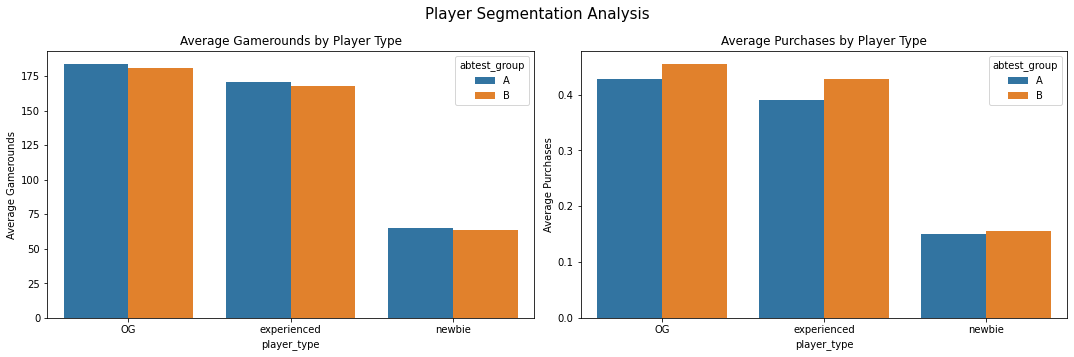

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x="player_type", y="total_gameends", hue="abtest_group", data=player_types, ax=ax[0])
sns.barplot(x="player_type", y="total_purchases", hue="abtest_group", data=player_types, ax=ax[1])

fig.suptitle("Player Segmentation Analysis", fontsize=15)
ax[0].set_title("Average Gamerounds by Player Type")
ax[0].set_ylabel("Average Gamerounds")
ax[1].set_title("Average Purchases by Player Type")
ax[1].set_ylabel("Average Purchases")
plt.tight_layout(pad=1)
plt.show()

The treatment's engagement and monetization lift appears less extreme for newbies for both gamerounds and purchases. Newbies are those that have installed the game after the start of the ab test and thus had never seen the control version of the game. 

This suggests that there isn't a significant difference between the two versions for new players, at least during the first weeks of play. 

## 5. What type of change to the game do you think was tested here?

Knowing the type of change introduced to the game is important before deciding whether to recommend the treatment or reject it.

Let's remember the business problem! Players need to solve math questions to progress through a map. The game is Free to Play meaning that players can download and play the game for free but can optionally buy hints on the levels.

The results show an increase in the average purchases (although statistically not significant) that starts falling after the first week, but a decrease in engagement. We also see that the change has almost no effect on new players. 

This seems to suggest that the next set of new levels has been introduced to the game. The hypothesis would explain why the change has almost no effect on new players -they are unlikely to reach these higher levels in just a couple of weeks-, and would explain both an increase in purchases and a slight decrease in engagement -now players have more levels to get stuck on and pay (particularly experienced players that had reached the end), but the fact that the later levels are harder can make them lose the motivation to keep playing-. The sudden drop of purchases after a week could be explained by the experienced players reaching the final level again.


## 5. Conclusion

In this experiment, we analyzed the data provided to determine wether the test variant makes Super Math Saga a better game. The main takaways are as follows:

The results of the analysis indicate that there is a statistical significance that the test group has a lower engagement than the control group. 

In terms of monetization, we have not been able to proof that the test variant produces a statistical significant lift over the control. Additionally, we have observed that despite an initial increase in purchases of the test variant on the first few days of the test, the trend starts to fall thereafter until the two variants look nearly identical.

A further analysis by player type suggests that the two variants perform nearly identically in new players in terms of engagement and monetization, and the effect mainly affects more experienced players.

For all these reasons and without more information on the experiment that was performed, we cannot conclude that the change introduced to the game is a significant improvement over the control variant, and we cannot recommend that the test variant is launched. 